In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%matplotlib inline
%load_ext autoreload
%autoreload 2

/scratch/eberha0001/slurm-job.1907670/ipykernel_92685/47907170.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from grakel.kernels import WeisfeilerLehman
from gpytorch.kernels import RBFKernel
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.models import GIN

from mobius import ExpectedImprovement, Pool, Planner
from mobius import GPGKModel, GPModel, GPGNNModel
from mobius import Graph, Map4Fingerprint
from mobius import TanimotoSimilarityKernel

## Permeability dataset

Citation: CycPeptMPDB: A Comprehensive Database of Membrane Permeability of Cyclic Peptides; Jianan Li, et al.; 2023; https://doi.org/10.1021/acs.jcim.2c01573

In [4]:
dataset = pd.read_csv('../data/CycPeptMPDB_Peptide_All.csv')
subset = dataset[['SMILES', 'Permeability']].copy().dropna()
subset = subset[subset['Permeability'] != -10].copy()

# Sort peptides from worst to best permeability. The first 96 peptides will be used as the seed library.
subset = subset.sort_values(by='Permeability', ascending=False)

/scratch/eberha0001/slurm-job.1907670/ipykernel_92685/1994354115.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('../data/CycPeptMPDB_Peptide_All.csv')


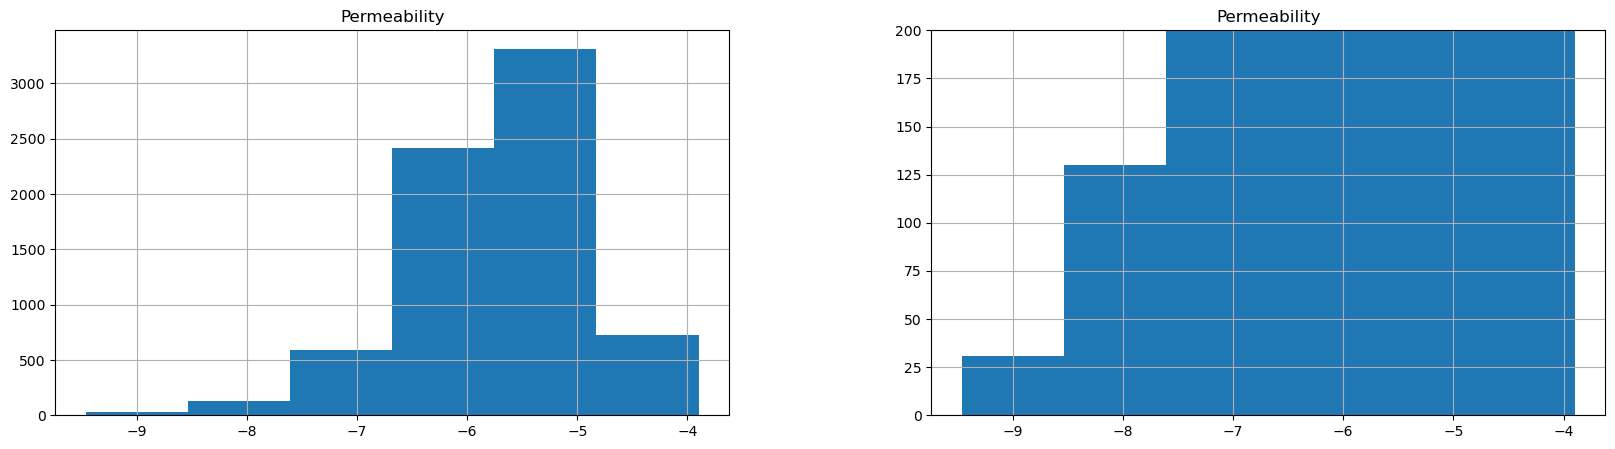

In [5]:
fig, axarr = plt.subplots(1, 2, figsize=(20, 5))

subset.hist(ax=axarr[0], bins=6)
subset.hist(ax=axarr[1], bins=6)
axarr[1].set_ylim([0, 200])

plt.show()

## Random search

In [11]:
pool = subset.copy()

peptides = pool['SMILES'][:96].values
scores = pool['Permeability'][:96].values

data = [(0, p, s) for p, s in zip(peptides, scores)]

pool = pool[~pool['SMILES'].isin(peptides)]

for i in range(5):
    suggested_peptides = np.random.choice(subset['SMILES'], size=96, replace=False)
    scores_suggested_peptides = [subset[subset['SMILES'] == p]['Permeability'].values[0] for p in suggested_peptides]

    pool = pool[~pool['SMILES'].isin(suggested_peptides)]
    
    data.extend([(i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

df = pd.DataFrame(data=data, columns=('iter', 'polymer', 'exp_value'))
df.to_csv('results_optimization_random.csv', index=False)

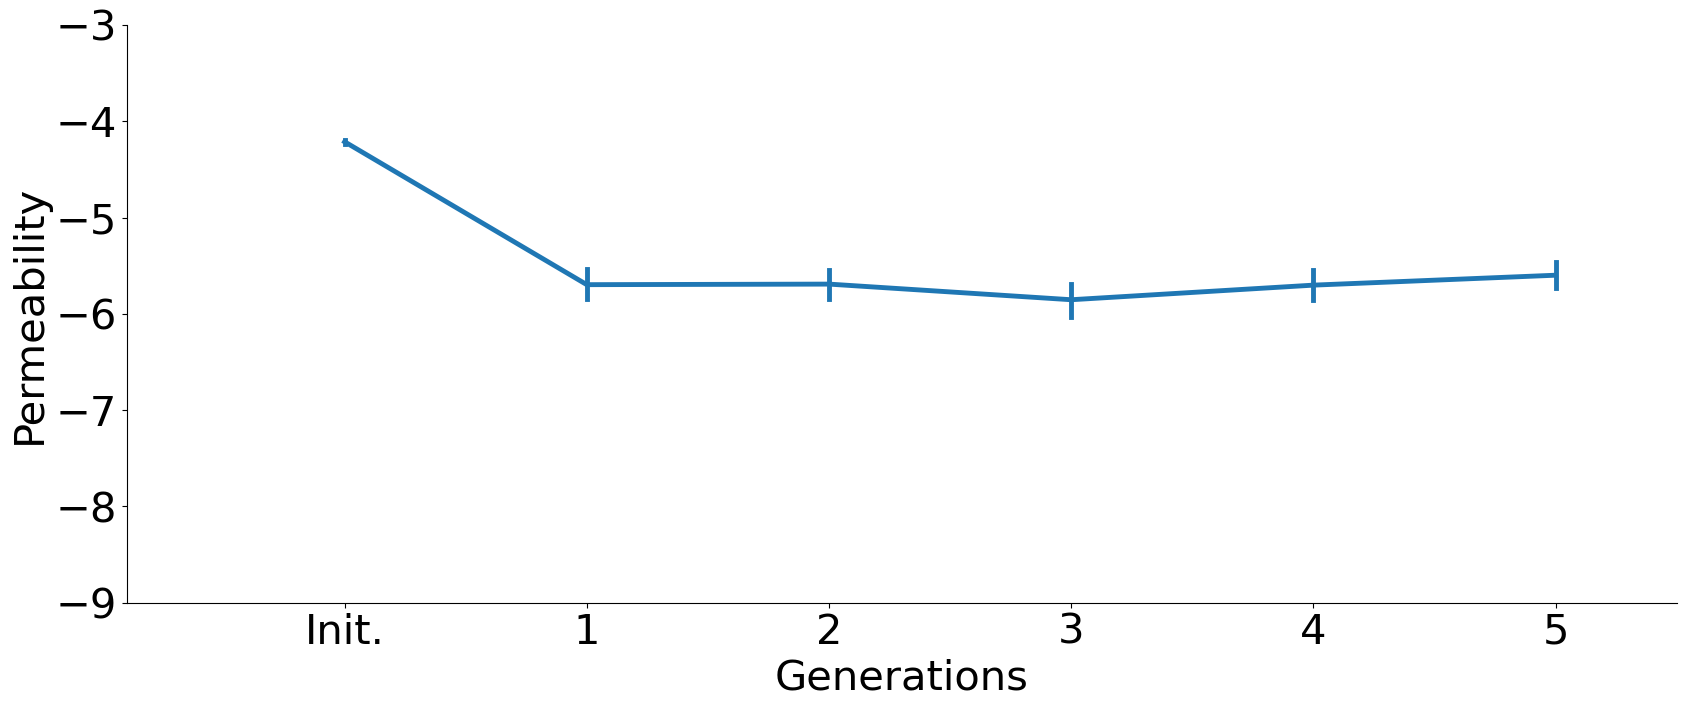

In [12]:
fig, ax = plt.subplots(figsize=(20, 7.5))

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='exp_value', data=df, ax=ax, errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

ax.set_xlim([-0.9, 5.5])
ax.set_ylim([-9, -3])
ax.set_ylabel('Permeability', fontsize=30)
ax.set_xlabel('Generations', fontsize=30)
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)

sns.despine()
plt.show()

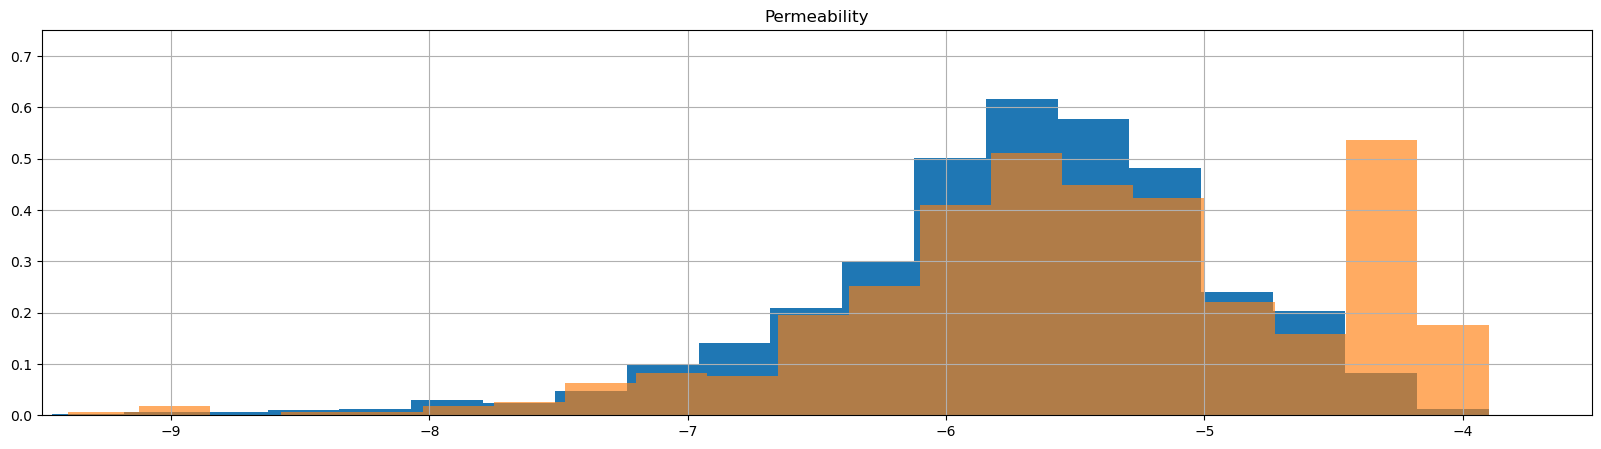

In [13]:
fig, axarr = plt.subplots(figsize=(20, 5), sharex=True)

subset.hist(ax=axarr, density=True, bins=20)
df['exp_value'].hist(ax=axarr, density=True, alpha=0.65, bins=20)
axarr.set_xlim([-9.5, -3.5])
axarr.set_ylim([0, 0.75])

plt.show()

## Graph kernel

In [5]:
graph_convertor = Graph(input_type='smiles', output_type='grakel')
kernel = WeisfeilerLehman(normalize=True)
gpmodel = GPGKModel(kernel=kernel, transform=graph_convertor)

In [6]:
acq = ExpectedImprovement(gpmodel, maximize=False)
optimizer = Pool(subset['SMILES'].values)
ps = Planner(acq, optimizer)

In [7]:
seed_library = subset['SMILES'][:96].values
scores_seed_library = subset['Permeability'][:96].values

In [8]:
peptides = seed_library.copy()
scores = scores_seed_library.copy()

# Store data for later analysis
data = [(0, p, s) for p, s in zip(peptides, scores)]

for i in range(5):
    suggested_peptides, _ = ps.recommand(peptides, scores.reshape(-1, 1), batch_size=96)

    # Get real permeability scores
    scores_suggested_peptides = [subset[subset['SMILES'] == p]['Permeability'].values[0] for p in suggested_peptides]

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([(i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    best_seq = peptides[np.argmin(scores)]
    best_scores = np.min(scores)
    print('Best peptide: %s / %.3f' % (best_seq, best_scores))
    print('')

df = pd.DataFrame(data=data, columns=('iter', 'polymer', 'exp_value'))
df.to_csv('results_optimization_graph.csv', index=False)

/scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mm/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mm/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


Best peptide: CC(C)C[C@H]1NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@@H]2CCCN2[C@H](C(=O)NC(C)(C)C)[C@H](C)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](Cc2ccc(O)cc2)NC1=O / -8.800

Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CO)NC(=O)[C@@H]2CCCN2[C@H](C(=O)NC(C)(C)C)[C@H](C)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](Cc2ccc(O)cc2)NC1=O / -9.100

Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CO)NC(=O)[C@@H]2CCCN2[C@H](C(=O)NC(C)(C)C)[C@H](C)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](Cc2ccc(O)cc2)NC1=O / -9.100

Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CO)NC(=O)[C@@H]2CCCN2[C@H](C(=O)NC(C)(C)C)[C@H](C)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](Cc2ccc(O)cc2)NC1=O / -9.100

Best peptide: CCC(C)[C@@H]1OC(=O)[C@H](CCC(N)=O)N(C)C(=O)[C@H](C(C)C)NC(=O)[C@@H]2CCCCN2C(=O)[C@H]([C@@H](C)CC)NC(=O)[C@H](CCC(N)=O)N(C)C(=O)[C@H](C(C)C)N(C)C(=O)CNC(=O)[C@@H]2CCCN2C(=O)[C@H](Cc2ccccc2)NC1=O / -9.400



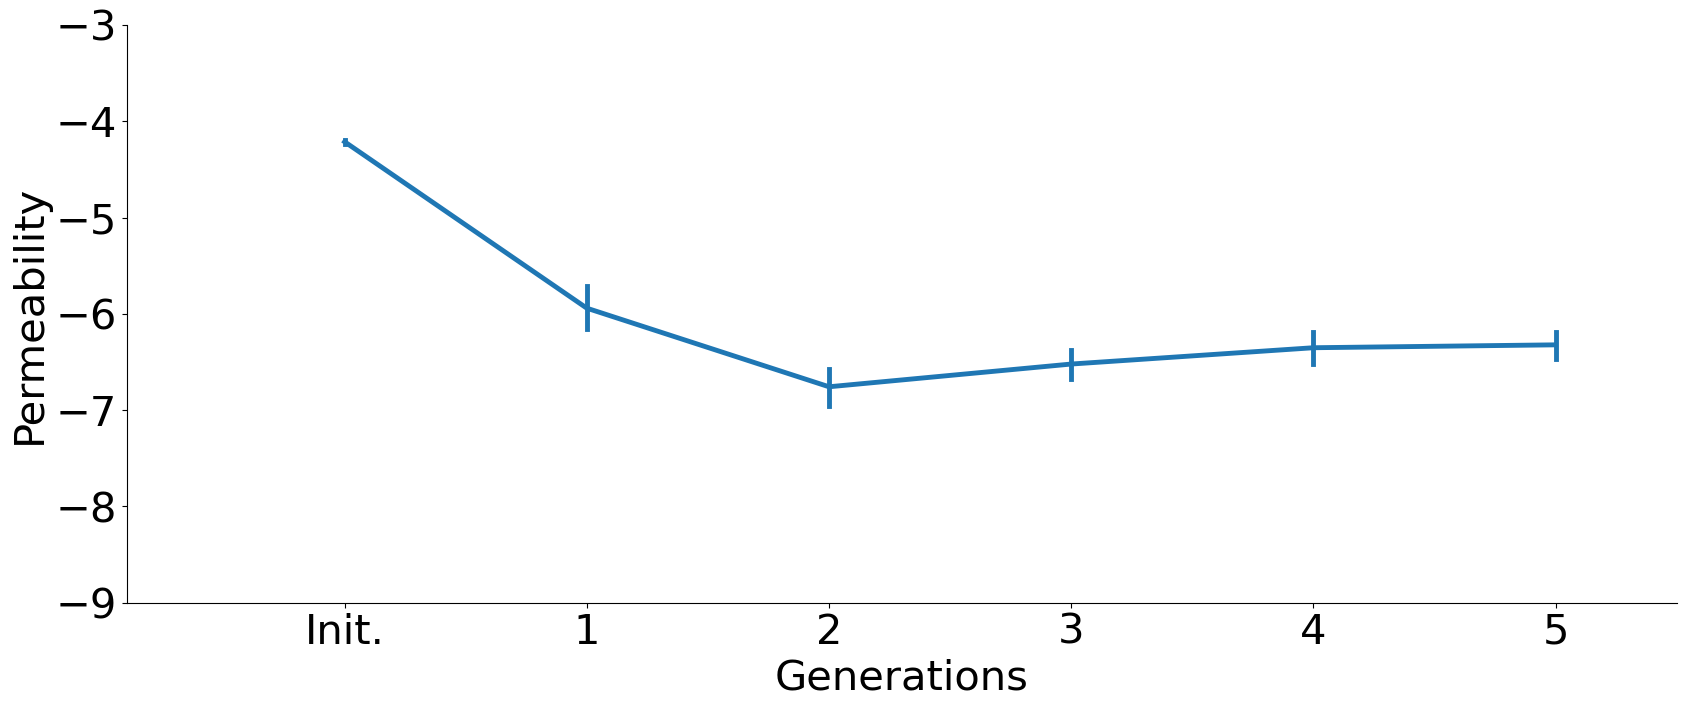

In [9]:
fig, ax = plt.subplots(figsize=(20, 7.5))

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='exp_value', data=df, ax=ax, errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

ax.set_xlim([-0.9, 5.5])
ax.set_ylim([-9, -3])
ax.set_ylabel('Permeability', fontsize=30)
ax.set_xlabel('Generations', fontsize=30)
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)

sns.despine()
plt.show()

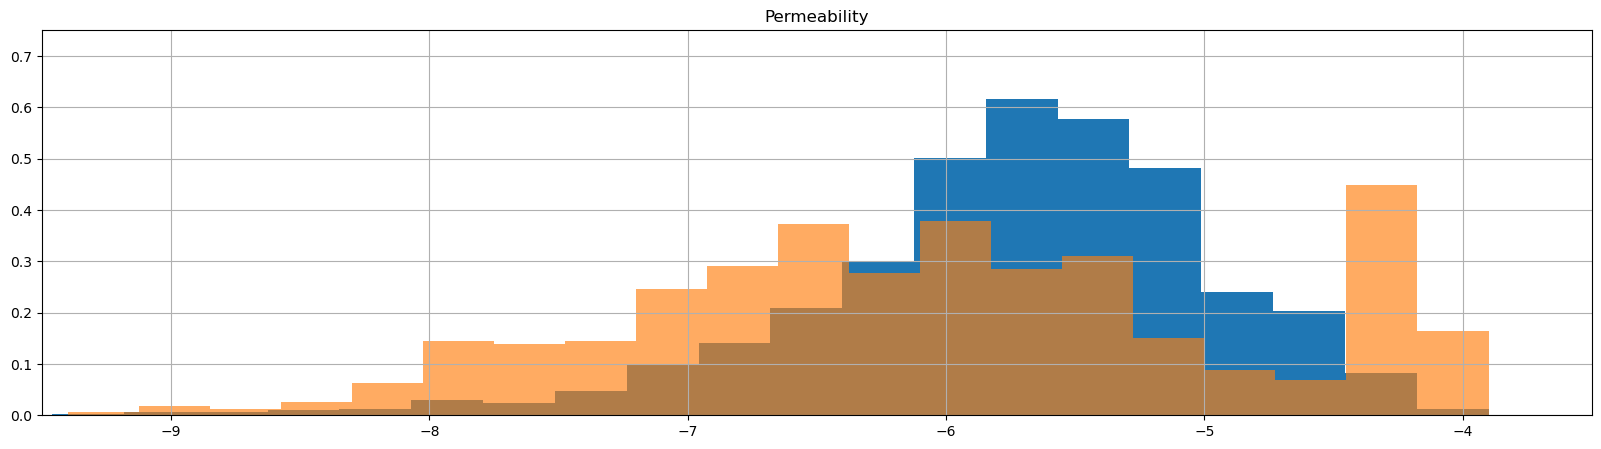

In [10]:
fig, axarr = plt.subplots(figsize=(20, 5), sharex=True)

subset.hist(ax=axarr, density=True, bins=20)
df['exp_value'].hist(ax=axarr, density=True, alpha=0.65, bins=20)
axarr.set_xlim([-9.5, -3.5])
axarr.set_ylim([0, 0.75])

plt.show()

## MAP4 fingerprint

In [22]:
map4 = Map4Fingerprint(input_type='smiles', chiral=False)
gp = GPModel(kernel=TanimotoSimilarityKernel(), transform=map4)

In [23]:
acq = ExpectedImprovement(gp, maximize=False)
optimizer = Pool(subset['SMILES'].values)
ps = Planner(acq, optimizer)

In [24]:
seed_library = subset['SMILES'][:96].values
scores_seed_library = subset['Permeability'][:96].values

In [25]:
peptides = seed_library.copy()
scores = scores_seed_library.copy()

# Store data for later analysis
data = [(0, p, s) for p, s in zip(peptides, scores)]

for i in range(5):
    suggested_peptides, _ = ps.recommand(peptides, scores.reshape(-1, 1), batch_size=96)

    # Get real permeability scores
    scores_suggested_peptides = [subset[subset['SMILES'] == p]['Permeability'].values[0] for p in suggested_peptides]

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([(i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    best_seq = peptides[np.argmin(scores)]
    best_scores = np.min(scores)
    print('Best peptide: %s / %.3f' % (best_seq, best_scores))
    print('')

df = pd.DataFrame(data=data, columns=('iter', 'polymer', 'exp_value'))
df.to_csv('results_optimization_map4.csv', index=False)

Best peptide: CC[C@H](C)[C@@H]1NC(=O)CNC(=O)[C@@H](C)N(C)C(=O)[C@H](C(C)C)NC(=O)[C@H]([C@@H](C)O)N(C)C(=O)[C@H](C(C)C)NC(=O)[C@H]([C@@H](C)O)N(C)C(=O)[C@H](C(C)C)NC(=O)CNC(=O)[C@@H](Cc2ccccc2)N(C)C(=O)[C@H](C(C)C)NC(=O)[C@H](CO)NC(=O)[C@H](C(C)C)N(C)C(=O)[C@H](CO)N(C)C1=O / -8.390

Best peptide: CCCC[C@@H]1NC(=O)[C@H](CC(C)C)NC(=O)CN(CC2CCOCC2)C(=O)[C@@H](C)NC(=O)CN(CC)C(=O)[C@@H]2CCCN2C1=O / -8.880

Best peptide: CCCC[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)CN(CCCN2CCCC2=O)C(=O)[C@H](C)NC(=O)CN(CCN2CCOCC2)C(=O)[C@H]2CCCN2C1=O / -9.000

Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CO)NC(=O)[C@@H]2CCCN2[C@H](C(=O)NC(C)(C)C)[C@H](C)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](Cc2ccc(O)cc2)NC1=O / -9.100



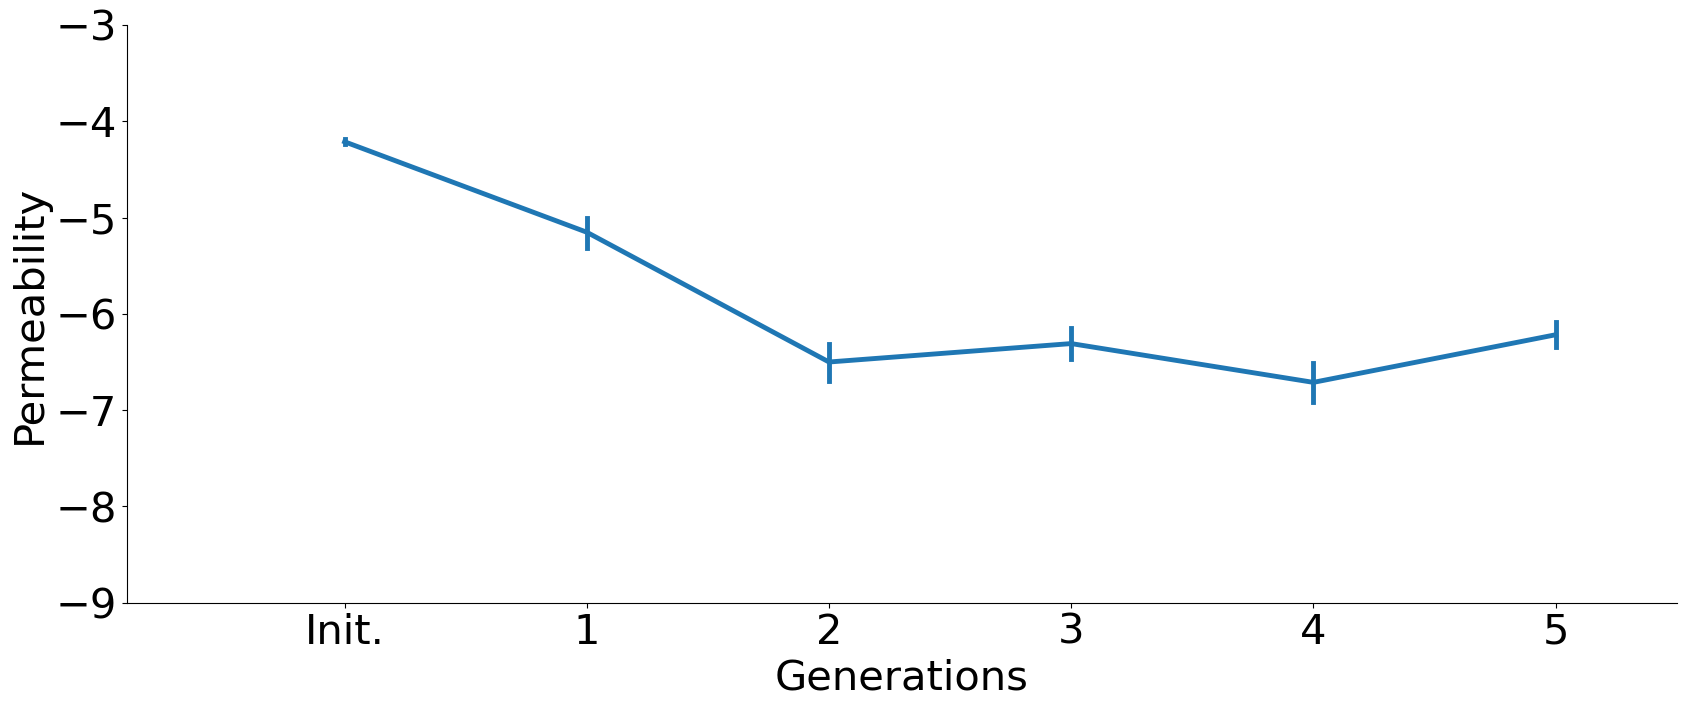

In [26]:
fig, ax = plt.subplots(figsize=(20, 7.5))

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='exp_value', data=df, ax=ax, errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

ax.set_xlim([-0.9, 5.5])
ax.set_ylim([-9, -3])
ax.set_ylabel('Permeability', fontsize=30)
ax.set_xlabel('Generations', fontsize=30)
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)

sns.despine()
plt.show()

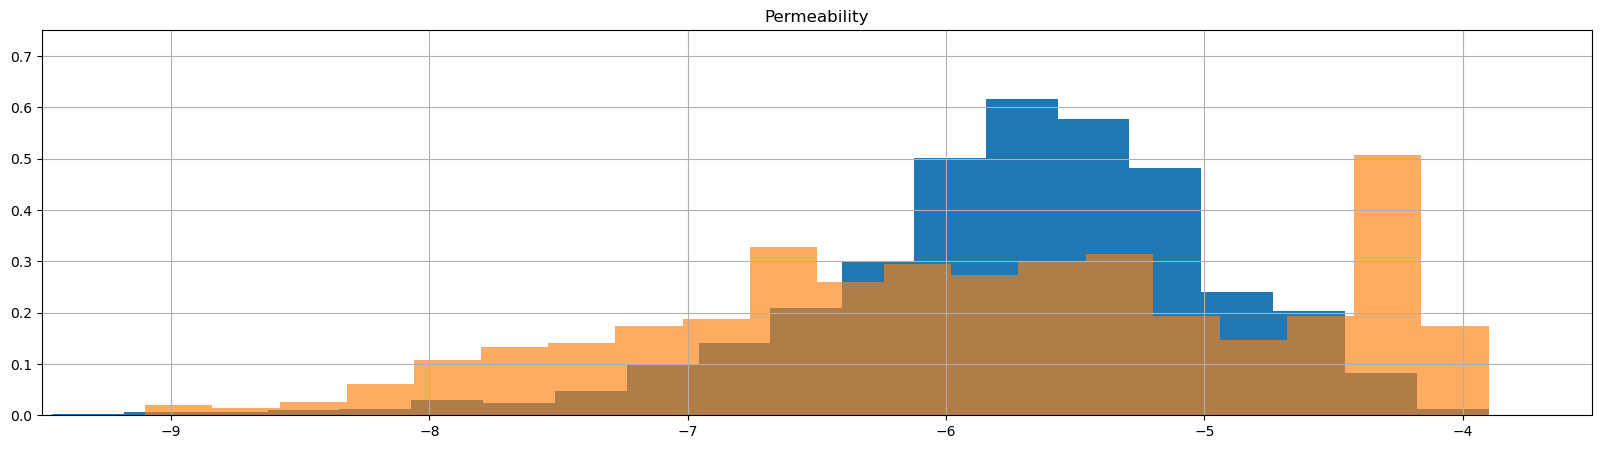

In [27]:
fig, axarr = plt.subplots(figsize=(20, 5), sharex=True)

subset.hist(ax=axarr, density=True, bins=20)
df['exp_value'].hist(ax=axarr, density=True, alpha=0.65, bins=20)
axarr.set_xlim([-9.5, -3.5])
axarr.set_ylim([0, 0.75])

plt.show()

## MAP4 chiral fingerprint

In [6]:
map4 = Map4Fingerprint(input_type='smiles', chiral=True)
gp = GPModel(kernel=TanimotoSimilarityKernel(), transform=map4)

In [7]:
acq = ExpectedImprovement(gp, maximize=False)
optimizer = Pool(subset['SMILES'].values)
ps = Planner(acq, optimizer)

In [8]:
seed_library = subset['SMILES'][:96].values
scores_seed_library = subset['Permeability'][:96].values

In [9]:
peptides = seed_library.copy()
scores = scores_seed_library.copy()

# Store data for later analysis
data = [(0, p, s) for p, s in zip(peptides, scores)]

for i in range(5):
    suggested_peptides, _ = ps.recommand(peptides, scores.reshape(-1, 1), batch_size=96)

    # Get real permeability scores
    scores_suggested_peptides = [subset[subset['SMILES'] == p]['Permeability'].values[0] for p in suggested_peptides]

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([(i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    best_seq = peptides[np.argmin(scores)]
    best_scores = np.min(scores)
    print('Best peptide: %s / %.3f' % (best_seq, best_scores))
    print('')

df = pd.DataFrame(data=data, columns=('iter', 'polymer', 'exp_value'))
df.to_csv('results_optimization_map4c.csv', index=False)

Best peptide: CC(C)C[C@@H]1NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CC(C)C)N(C)C(=O)C[C@@H](C(=O)N2CCCCC2)NC(=O)[C@H](COC(C)(C)C)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)CN(C)C(=O)[C@H](Cc2ccccc2)N(C)C(=O)[C@H](Cc2ccccc2)N(C)C1=O / -7.720

Best peptide: CC(C)C[C@@H]1NC(=O)CN(C)C(=O)[C@H](Cc2ccccc2)N(C)C(=O)[C@@H](C)NC(=O)C[C@@H](C(=O)N2CCCCC2)NC(=O)[C@H](Cc2ccccc2)N(C)C(=O)[C@H](Cc2ccccc2)N(C)C(=O)[C@H](COC(C)(C)C)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H]([C@@H](C)O)NC1=O / -7.850

Best peptide: CCCC[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)CN(CCOc2ccccc2)C(=O)[C@H](Cc2ccc3ccccc3c2)NC(=O)CN(Cc2ccc(Cl)cc2)C(=O)[C@H]2CCCN2C1=O / -9.410

Best peptide: CCCC[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)CN(Cc2ccccc2)C(=O)[C@H](Cc2ccc3ccccc3c2)NC(=O)CN(Cc2ccc(Cl)cc2)C(=O)[C@H]2CCCN2C1=O / -9.460

Best peptide: CCCC[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)CN(Cc2ccccc2)C(=O)[C@H](Cc2ccc3ccccc3c2)NC(=O)CN(Cc2ccc(Cl)cc2)C(=O)[C@H]2CCCN2C1=O / -9.460



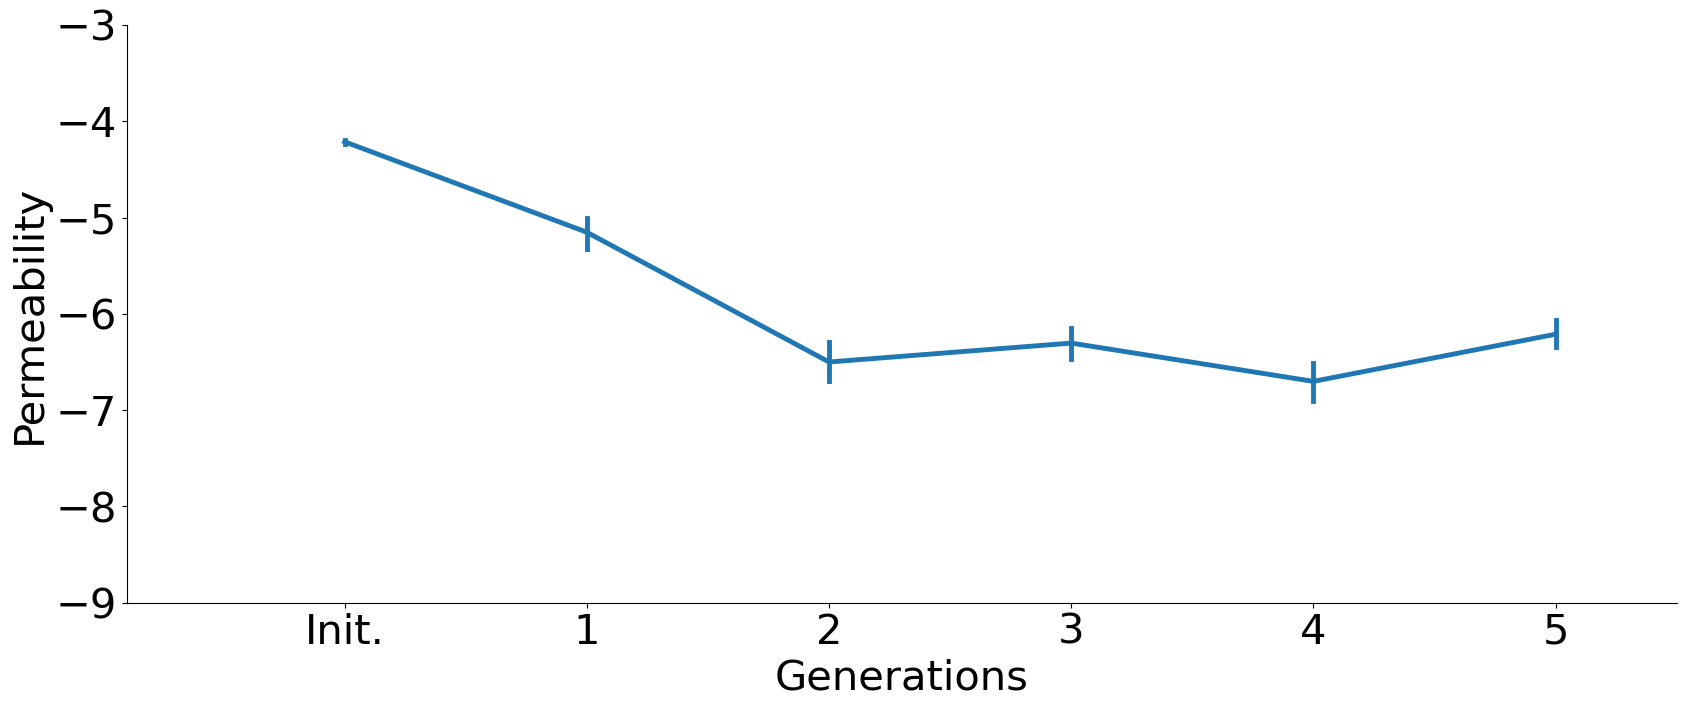

In [10]:
fig, ax = plt.subplots(figsize=(20, 7.5))

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='exp_value', data=df, ax=ax, errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

ax.set_xlim([-0.9, 5.5])
ax.set_ylim([-9, -3])
ax.set_ylabel('Permeability', fontsize=30)
ax.set_xlabel('Generations', fontsize=30)
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)

sns.despine()
plt.show()

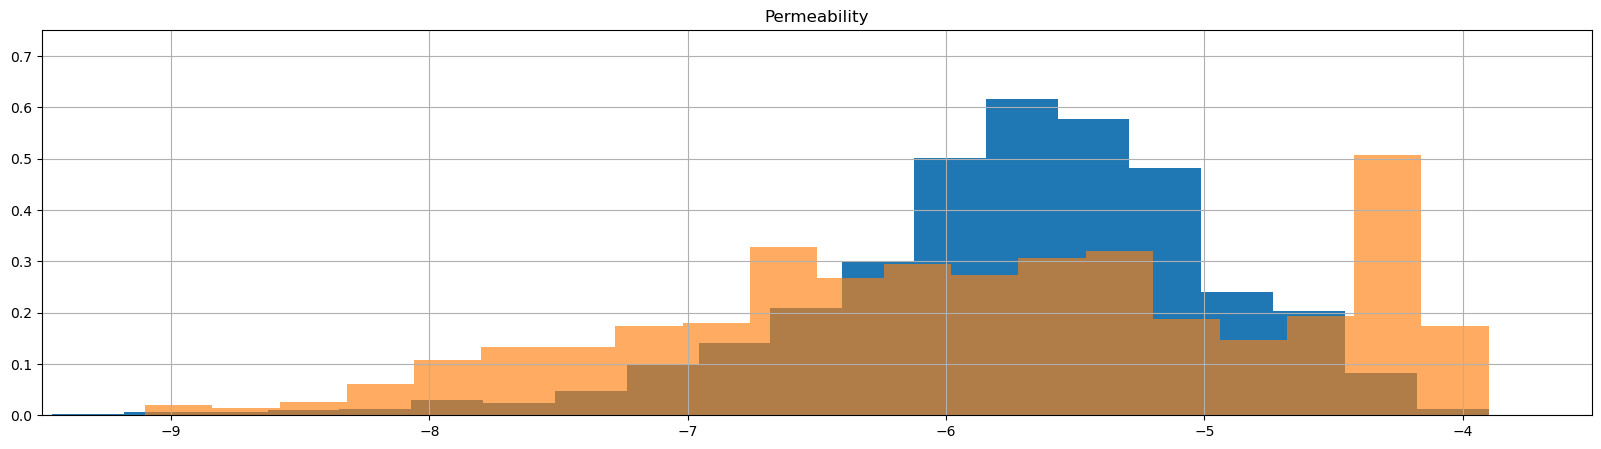

In [11]:
fig, axarr = plt.subplots(figsize=(20, 5), sharex=True)

subset.hist(ax=axarr, density=True, bins=20)
df['exp_value'].hist(ax=axarr, density=True, alpha=0.65, bins=20)
axarr.set_xlim([-9.5, -3.5])
axarr.set_ylim([0, 0.75])

plt.show()

## GNN model

In [11]:
class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(GNNModel, self).__init__()

        self.model = GIN(in_channels=in_channels, hidden_channels=hidden_channels, num_layers=num_layers, 
                         out_channels=out_channels, dropout=dropout)
        
        self._reset_parameters()

    def _reset_parameters(self):
        r"""Initiate parameters in the transformer model."""

        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

    def forward(self, x):
        node_attr, edge_index, edge_attr, batch = x.node_attr, x.edge_index, x.edge_attr, x.batch
        x = self.model(x=node_attr, edge_index=edge_index, edge_attr=edge_attr, batch=batch)
        x = global_mean_pool(x, batch)

        return x

In [12]:
graph_convertor = Graph(input_type='smiles', output_type='pyg')

In [13]:
graphs = graph_convertor.transform(subset['SMILES'].values[0])
gnn = GNNModel(in_channels=graphs.node_attr.shape[1], hidden_channels=128, out_channels=128, num_layers=1, dropout=0.25)

In [14]:
gpmodel = GPGNNModel(kernel=RBFKernel(), model=gnn, transform=graph_convertor)

In [15]:
acq = ExpectedImprovement(gpmodel , maximize=False)
optimizer = Pool(subset['SMILES'].values)
ps = Planner(acq, optimizer)

In [16]:
seed_library = subset['SMILES'][:96].values
scores_seed_library = subset['Permeability'][:96].values

In [ ]:
peptides = seed_library.copy()
scores = scores_seed_library.copy()

# Store data for later analysis
data = [(0, p, s) for p, s in zip(peptides, scores)]

for i in range(5):
    suggested_peptides, _ = ps.recommand(peptides, scores.reshape(-1, 1), batch_size=96)

    # Get real permeability scores
    scores_suggested_peptides = [subset[subset['SMILES'] == p]['Permeability'].values[0] for p in suggested_peptides]

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([(i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    best_seq = peptides[np.argmin(scores)]
    best_scores = np.min(scores)
    print('Best peptide: %s / %.3f' % (best_seq, best_scores))
    print('')

df = pd.DataFrame(data=data, columns=('iter', 'polymer', 'exp_value'))
df.to_csv('results_optimization_gin.csv', index=False)

Best peptide: CCCC[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)CN(CCCc2ccccc2)C(=O)[C@H](Cc2ccccc2)NC(=O)CN(CCCCc2ccccc2)C(=O)[C@H]2CCCN2C1=O / -8.510



In [3]:
df = pd.read_csv('results_optimization_gin.csv')

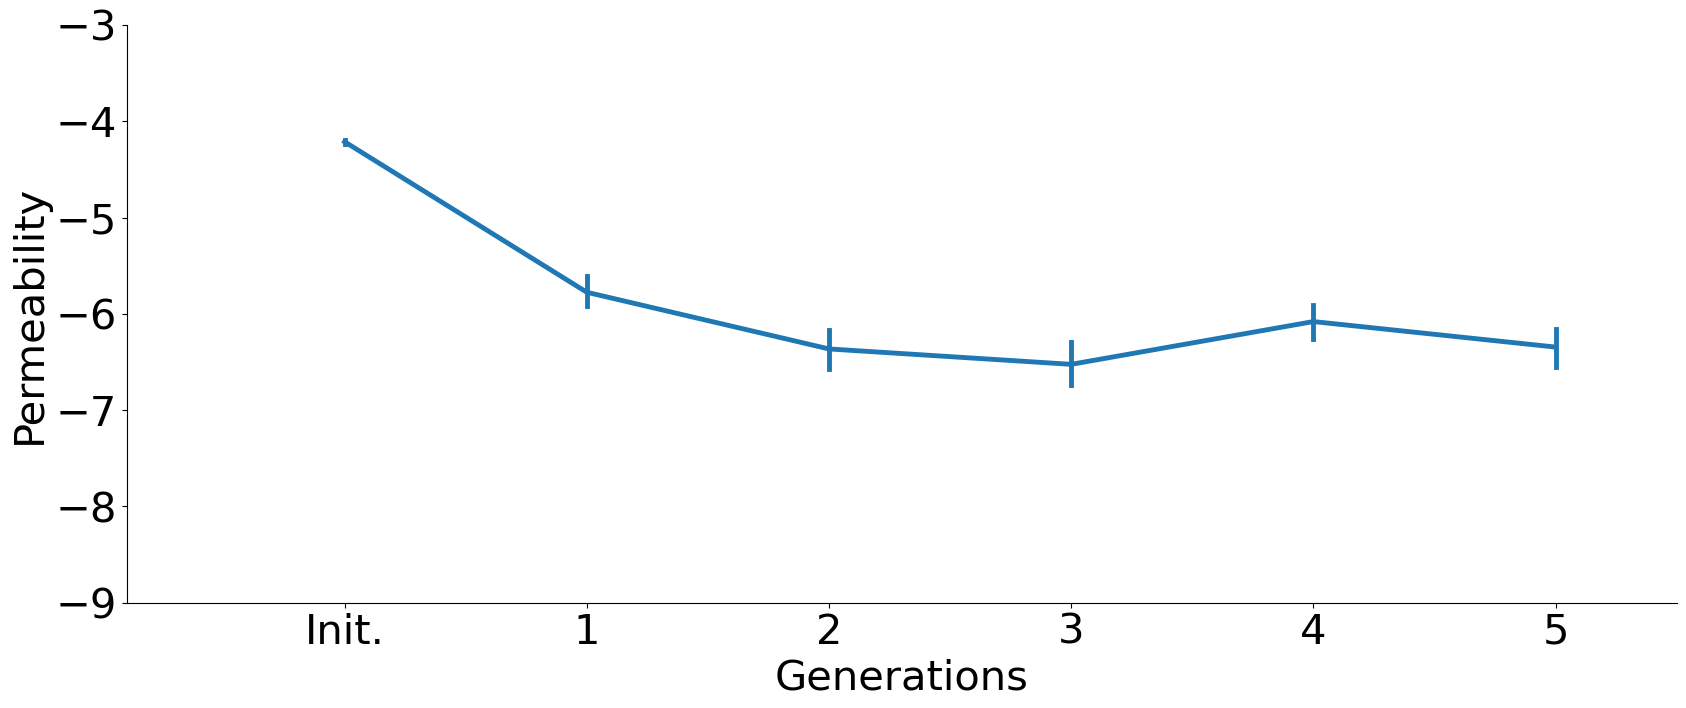

In [4]:
fig, ax = plt.subplots(figsize=(20, 7.5))

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='exp_value', data=df, ax=ax, errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

ax.set_xlim([-0.9, 5.5])
ax.set_ylim([-9, -3])
ax.set_ylabel('Permeability', fontsize=30)
ax.set_xlabel('Generations', fontsize=30)
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)

sns.despine()
plt.show()

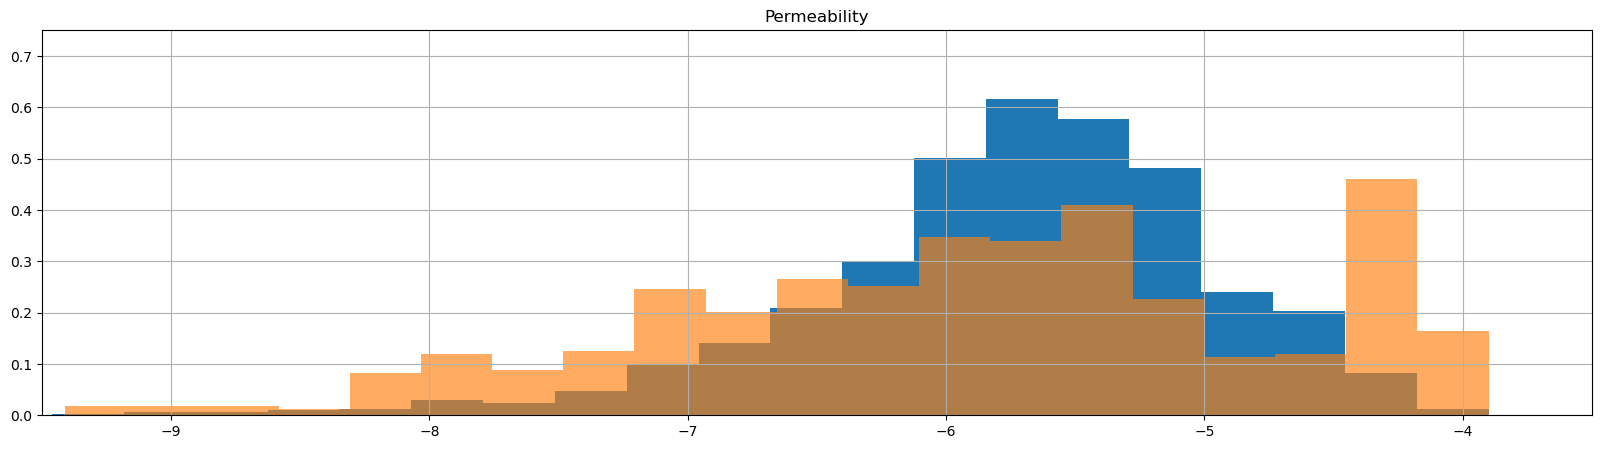

In [8]:
fig, axarr = plt.subplots(figsize=(20, 5), sharex=True)

subset.hist(ax=axarr, density=True, bins=20)
df['exp_value'].hist(ax=axarr, density=True, alpha=0.65, bins=20)
axarr.set_xlim([-9.5, -3.5])
axarr.set_ylim([0, 0.75])

plt.show()

# Results comparison

In [29]:
df_0 = pd.read_csv('results_optimization_random.csv')
df_0['method'] = 'random'

df_1 = pd.read_csv('results_optimization_map4.csv')
df_1['method'] = 'map4'

df_2 = pd.read_csv('results_optimization_map4c.csv')
df_2['method'] = 'map4c'

df_3 = pd.read_csv('results_optimization_graph.csv')
df_3['method'] = 'graph'

df_4 = pd.read_csv('results_optimization_gin.csv')
df_4['method'] = 'gin'

df = pd.concat([df_0, df_1, df_2, df_3, df_4])

## Evolution of the permeability scores (average)

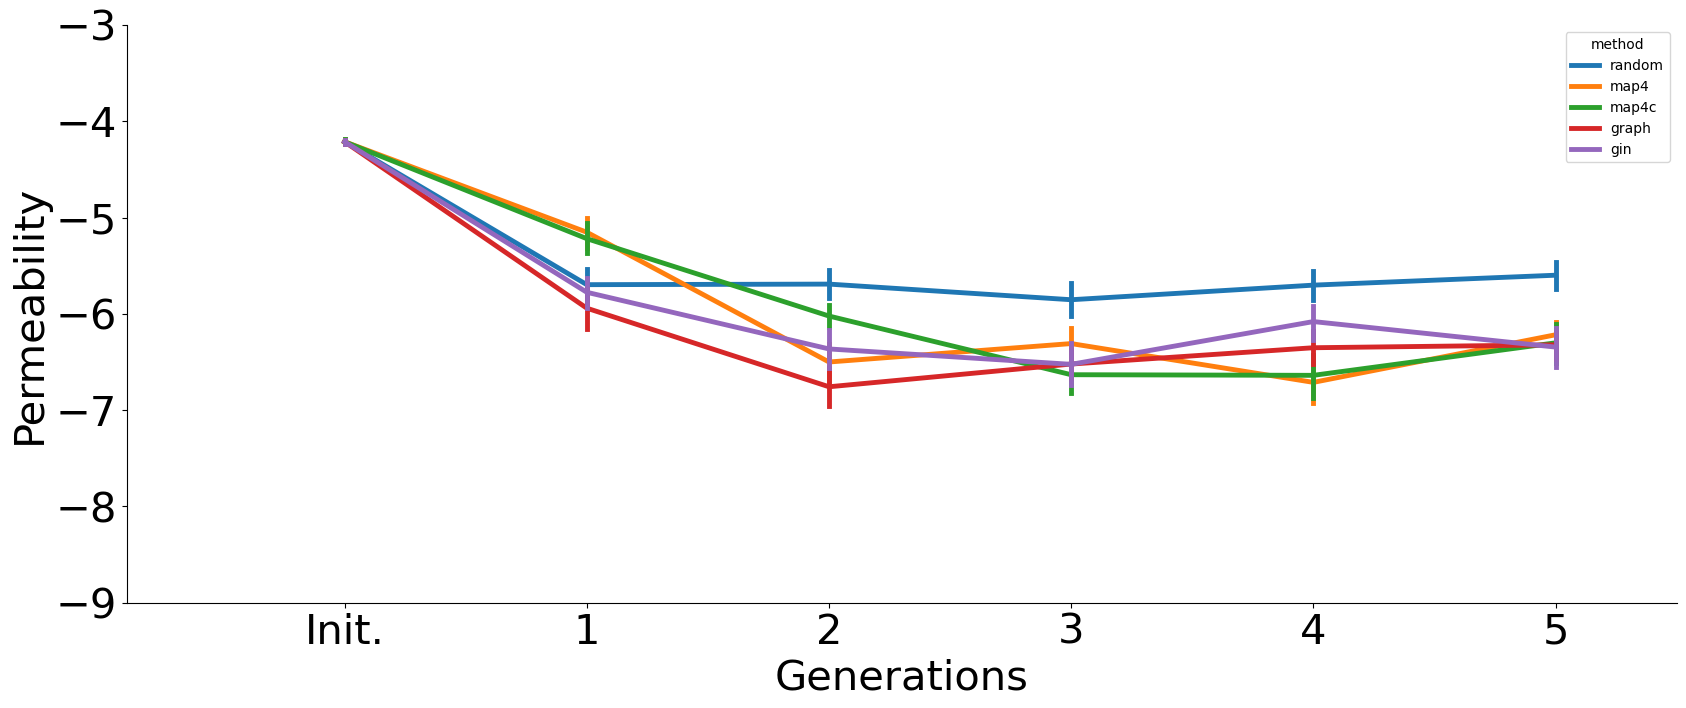

In [30]:
fig, ax = plt.subplots(figsize=(20, 7.5))

df_tmp = df.copy()
df_tmp['iter'] = df_tmp['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='exp_value', hue='method', data=df_tmp, ax=ax, errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

ax.set_xlim([-0.9, 5.5])
ax.set_ylim([-9, -3])
ax.set_ylabel('Permeability', fontsize=30)
ax.set_xlabel('Generations', fontsize=30)
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)

sns.despine()
plt.show()

## Evolution of the permeability scores (best)

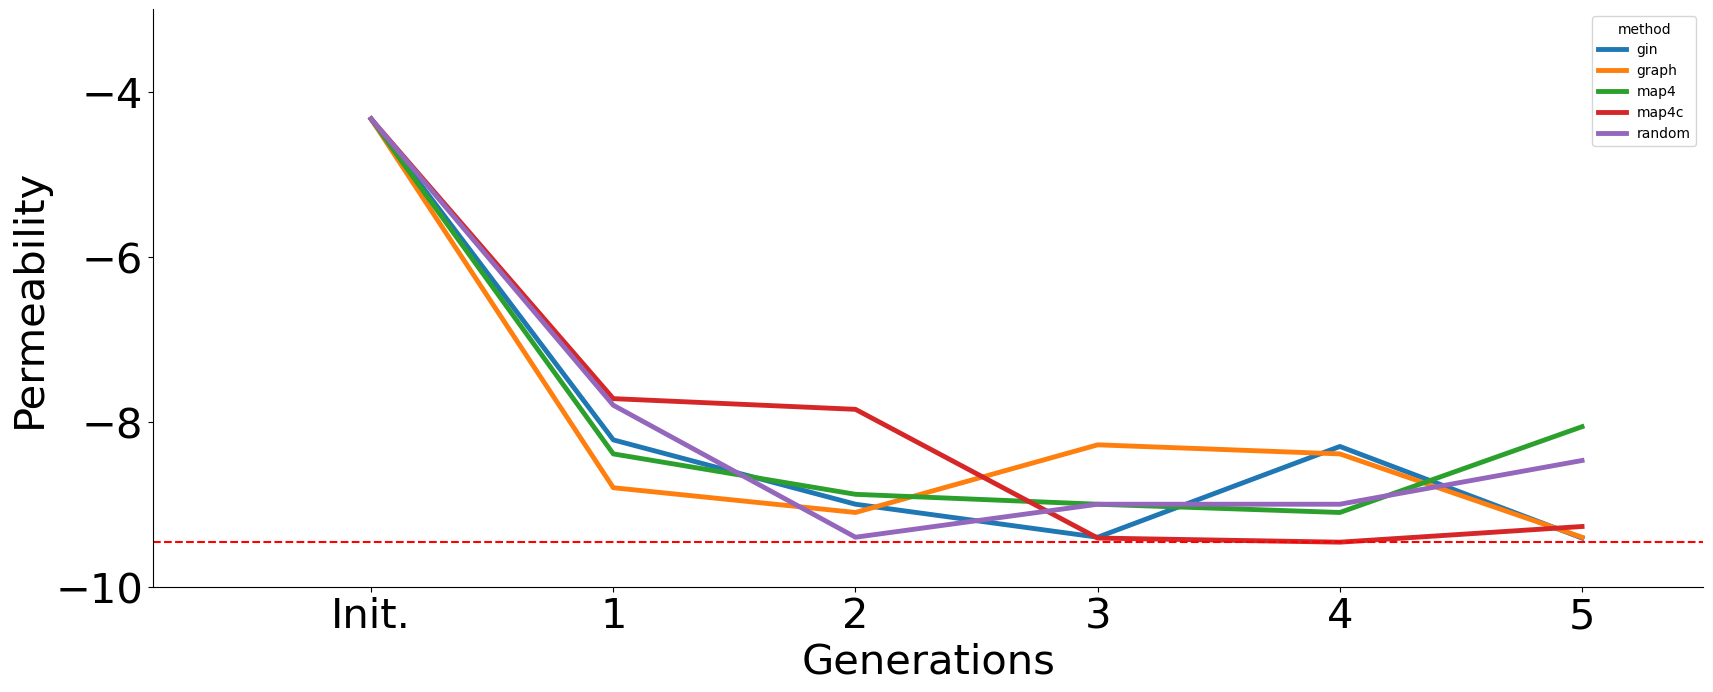

In [32]:
fig, ax = plt.subplots(figsize=(20, 7.5))

# pandas dataframe (df) columns: iter, peptide, exp_value
df_min = df.groupby(['method', 'iter'])['exp_value'].agg('min')
df_min = df_min.reset_index(level=['method', 'iter'])

df_min['iter'] = df_min['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='exp_value', hue='method', data=df_min, ax=ax, errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})
plt.axhline(y=np.min(subset['Permeability']), color='r', linestyle='--')

ax.set_xlim([-0.9, 5.5])
ax.set_ylim([-10, -3])
ax.set_ylabel('Permeability', fontsize=30)
ax.set_xlabel('Generations', fontsize=30)
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)

sns.despine()
plt.show()

## Enrichment factors (1, 5 and 10%)

Consider macrocyclic peptides with permebability scores equal or below -9 as active

In [33]:
def enrichment_factor(sample, database, cutoff, percentage=0.10):
    s = sample.sort_values(by='exp_value', ascending=True)[:int(len(sample) * percentage)]
    s[s['exp_value'] <= cutoff]
    
    hit_sample = len(s[s['exp_value'] <= cutoff])
    n_sample = len(s)
    hit_ref = len(database[database['Permeability'] <= cutoff])
    n_ref = len(database)
    
    ef = (hit_sample / n_sample) / (hit_ref / n_ref)

    return ef

In [37]:
pc = 0.01
print(f'Random        : {enrichment_factor(df_0, subset, -9, pc):.3f}')
print(f'MAP4          : {enrichment_factor(df_1, subset, -9, pc):.3f}')
print(f'MAP4  chiral  : {enrichment_factor(df_2, subset, -9, pc):.3f}')
print(f'Graph kernel  : {enrichment_factor(df_3, subset, -9, pc):.3f}')
print(f'GIN           : {enrichment_factor(df_4, subset, -9, pc):.3f}')

Random        : 411.943
MAP4          : 205.971
MAP4  chiral  : 514.929
Graph kernel  : 308.957
GIN           : 514.929


In [38]:
pc = 0.05
print(f'Random        : {enrichment_factor(df_0, subset, -9, pc):.3f}')
print(f'MAP4          : {enrichment_factor(df_1, subset, -9, pc):.3f}')
print(f'MAP4  chiral  : {enrichment_factor(df_2, subset, -9, pc):.3f}')
print(f'Graph kernel  : {enrichment_factor(df_3, subset, -9, pc):.3f}')
print(f'GIN           : {enrichment_factor(df_4, subset, -9, pc):.3f}')

Random        : 73.561
MAP4          : 36.781
MAP4  chiral  : 110.342
Graph kernel  : 55.171
GIN           : 91.952


In [39]:
pc = 0.10
print(f'Random        : {enrichment_factor(df_0, subset, -9, pc):.3f}')
print(f'MAP4          : {enrichment_factor(df_1, subset, -9, pc):.3f}')
print(f'MAP4  chiral  : {enrichment_factor(df_2, subset, -9, pc):.3f}')
print(f'Graph kernel  : {enrichment_factor(df_3, subset, -9, pc):.3f}')
print(f'GIN           : {enrichment_factor(df_4, subset, -9, pc):.3f}')

Random        : 36.135
MAP4          : 18.068
MAP4  chiral  : 54.203
Graph kernel  : 27.102
GIN           : 45.169
